In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlmodel import create_engine, SQLModel, Session, text
from dotenv import load_dotenv

load_dotenv()

db_host = os.environ.get("DB_HOST")
db_user = os.environ.get("DB_USER")
db_password = os.environ.get("DB_PASSWORD")
db_database = os.environ.get("DB_DATABASE")
db_port = os.environ.get("DB_PORT")


postgres_uri = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_database}"

engine = create_engine(postgres_uri, echo=False)

videosTable = "youtube_videos"
videoStatsTable = "youtube_video_stats"
channelsTable = "youtube_channels"
statsTable = "youtube_stats"

## Channel information

In [63]:
channelId = "31ad21f4-7b35-4a76-af1f-3f5be21b385f"

In [64]:
videoStatsQuery = f'''
SELECT
    {videoStatsTable}.video,
    MAX({videoStatsTable}.views) as views,
    MAX({videoStatsTable}.likes) as likes,
    MAX({videoStatsTable}.comments) as comments
FROM {videoStatsTable}
WHERE {videoStatsTable}.timestamp = (
    SELECT MAX(timestamp) FROM {videoStatsTable} AS latest
    WHERE latest.video = {videoStatsTable}.video
)
GROUP BY {videoStatsTable}.video
'''


channelStatsQuery = f'''
SELECT
    {statsTable}.youtube_channel,
    MAX({statsTable}.subs) as subs,
    MAX({statsTable}.videos) as about_videos
FROM {statsTable}
WHERE {statsTable}.timestamp = (
    SELECT MAX(timestamp) FROM {statsTable} AS latest
    WHERE latest.youtube_channel = {statsTable}.youtube_channel
)
GROUP BY {statsTable}.youtube_channel
'''




query = f'''
SELECT 
    {channelsTable}.username,
    COUNT({videosTable}.uuid) as videos,
    AVG(channel_stats.about_videos) as about_videos,
    AVG(channel_stats.subs) as subs,
    SUM(latest_video_stats.views) as views,
    SUM(latest_video_stats.likes) as likes,
    SUM(latest_video_stats.comments) as comments,
    AVG(latest_video_stats.views) as avg_views,
    AVG(latest_video_stats.likes) as avg_likes,
    AVG(latest_video_stats.comments) as avg_comments,
    MIN(latest_video_stats.views) as min_views,
    MIN(latest_video_stats.likes) as min_likes,
    MIN(latest_video_stats.comments) as min_comments,
    (SUM(latest_video_stats.views)/AVG(channel_stats.subs)) as views_per_sub,
    (SUM(latest_video_stats.likes) / SUM(latest_video_stats.views)) as likes_per_views,
    (SUM(latest_video_stats.comments) / SUM(latest_video_stats.views)) as comments_per_views,
    (AVG(channel_stats.subs) / COUNT({videosTable}.uuid)) as subs_per_video
FROM {videosTable}
    LEFT JOIN {channelsTable} ON {channelsTable}.uuid = {videosTable}.youtube_channel
    LEFT JOIN (
        {videoStatsQuery}
    ) latest_video_stats ON latest_video_stats.video = {videosTable}.uuid
    LEFT JOIN (
        {channelStatsQuery}
    ) channel_stats ON channel_stats.youtube_channel = {videosTable}.youtube_channel
WHERE
    {videosTable}.youtube_channel = '{channelId}'
GROUP BY {channelsTable}.username
'''


df = pd.read_sql(query, engine, index_col="username")
df.round(1).T

username,xaviesqueriguela
videos,73.0
about_videos,260.0
subs,11000.0
views,1551258.0
likes,7985.0
comments,1728.0
avg_views,21250.1
avg_likes,109.4
avg_comments,23.7
min_views,0.0


## Videos

In [65]:
query = f'''
SELECT
    {videosTable}.title,
    MAX({channelsTable}.username) as channel,
    MAX({videoStatsTable}.views) as views,
    MAX({videoStatsTable}.likes) as likes,
    MAX({videoStatsTable}.comments) as comments,
    MAX({videoStatsTable}.date) as date,
    CASE
        WHEN MAX({statsTable}.subs) > 0 THEN MAX({videoStatsTable}.views) / MAX({statsTable}.subs)
        ELSE 0.0 -- Handle division by zero by returning 0.0 (you can use NULL or another value as well)
    END as views_per_subs,
    CASE
        WHEN MAX({videoStatsTable}.views) > 0 THEN MAX({videoStatsTable}.likes) / MAX({videoStatsTable}.views)
        ELSE 0.0 -- Handle division by zero by returning 0.0 (you can use NULL or another value as well)
    END as likes_per_views,
    CASE
        WHEN MAX({videoStatsTable}.views) > 0 THEN MAX({videoStatsTable}.comments) / MAX({videoStatsTable}.views)
        ELSE 0.0 -- Handle division by zero by returning 0.0 (you can use NULL or another value as well)
    END as comments_per_views,
    MAX({statsTable}.subs) as subs
FROM {videosTable}
    LEFT JOIN {videoStatsTable} ON {videoStatsTable}.video = {videosTable}.uuid
    LEFT JOIN {statsTable} ON {statsTable}.youtube_channel = {videosTable}.youtube_channel
    LEFT JOIN {channelsTable} ON {channelsTable}.uuid = {videosTable}.youtube_channel
WHERE {videosTable}.youtube_channel = '{channelId}'
GROUP BY {videosTable}.title
'''
df = pd.read_sql(query, engine, index_col='title')

totalVideos = len(df.index)
nullDates = np.sum(pd.isnull(df['date']))
print(f"Null dates: {nullDates}/{totalVideos} ({round(nullDates/totalVideos*100, 2)}%)")

nullViews = np.sum(pd.isnull(df['views']))
print(f"Null views: {nullViews}/{totalVideos} ({round(nullViews/totalVideos*100, 2)}%)")

nullSubs = np.sum(pd.isnull(df['subs']))
print(f"Null subs: {nullSubs}/{totalVideos} ({round(nullSubs/totalVideos*100, 2)}%)")

df.sort_values(by=["views"], ascending=False)
df['interact'] = df['comments']*100/df['views']


Null dates: 12/73 (16.44%)
Null views: 0/73 (0.0%)
Null subs: 0/73 (0.0%)


### Top Videos

In [66]:
df.sort_values(by=["views"], ascending=False).head(10)

,channel,views,likes,comments,date,views_per_subs,likes_per_views,comments_per_views,subs,interact
title,,,,,,,,,,
Me voy a VIVIR a ANDORRA 🇦🇩 | Cuento los DETALLES,xaviesqueriguela,94150.0,1499.0,585.0,2022-11-09,8.559091,0.015921,0.006213,11000.0,0.621349
Mi REFLEXIÓN sobre los TATTOOS | Xavi Esquerigüela,xaviesqueriguela,64280.0,529.0,355.0,2022-05-16,5.843636,0.008230,0.005523,11000.0,0.552271
DEPORTE y NEGOCIOS (¿Tienen relación?),xaviesqueriguela,62836.0,241.0,8.0,2022-06-29,5.712364,0.003835,0.000127,11000.0,0.012732
⏰ ⏰ El CLUB de las 5 de la MAÑANA ⏰ ⏰,xaviesqueriguela,60478.0,814.0,289.0,2022-07-27,5.498000,0.013459,0.004779,11000.0,0.477860
La historia de Xavi Esquerigüela,xaviesqueriguela,57438.0,353.0,28.0,2022-05-24,5.221636,0.006146,0.000487,11000.0,0.048748
Me compro mi SEGUNDO ROLEX en Tienda de Andorra,xaviesqueriguela,55199.0,271.0,109.0,2023-07-09,5.018091,0.004910,0.001975,11000.0,0.197467
Crece tu canal de YouTube con Ads,xaviesqueriguela,52364.0,230.0,13.0,2022-07-13,4.760364,0.004392,0.000248,11000.0,0.024826
Testimonio de DAVID | Ha creado su AGENCIA con mis MENTORÍAS,xaviesqueriguela,51769.0,172.0,15.0,2023-02-19,4.706273,0.003322,0.000290,11000.0,0.028975
Mi ESTRATEGIA de NEGOCIO en TIK TOK,xaviesqueriguela,48536.0,207.0,16.0,2022-11-23,4.412364,0.004265,0.000330,11000.0,0.032965


## Worst videos

In [67]:
videosWithStats = df.loc[df['views'].notna()]
videosWithStats.sort_values(by=["views"], ascending=False).tail(10)

,channel,views,likes,comments,date,views_per_subs,likes_per_views,comments_per_views,subs,interact
title,,,,,,,,,,
MESA REDONDA con ALUMNOS en mi OFICINA,xaviesqueriguela,286.0,7.0,0.0,None,0.026000,0.024476,0.000000,11000.0,0.000000
Quique Vicens| TESTIMONIO - YOUTUBE ADS ACADEMY,xaviesqueriguela,270.0,5.0,0.0,2021-10-07,0.024545,0.018519,0.000000,11000.0,0.000000
Beatriz Calvo | TESTIMONIO - YOUTUBE ADS ACADEMY,xaviesqueriguela,263.0,3.0,0.0,2021-10-04,0.023909,0.011407,0.000000,11000.0,0.000000
Manuel Miñano | TESTIMONIO - YOUTUBE ADS ACADEMY,xaviesqueriguela,241.0,6.0,0.0,2021-10-04,0.021909,0.024896,0.000000,11000.0,0.000000
David Izquierdo | TESTIMONIO YOUTUBE ADS ACADEMY,xaviesqueriguela,212.0,4.0,1.0,2022-06-10,0.019273,0.018868,0.004717,11000.0,0.471698
Christian Helmut | TESTIMONIO - YOUTUBE ADS ACADEMY,xaviesqueriguela,202.0,5.0,0.0,2021-10-04,0.018364,0.024752,0.000000,11000.0,0.000000
"""Tú como MENTOR... un 10. La mejor formación"" | Testimonio de Fernanda",xaviesqueriguela,179.0,0.0,1.0,2023-08-27,0.016273,0.000000,0.005587,11000.0,0.558659
Las 5 CLAVES para HACER CRECER tu AGENCIA 🚀🚀,xaviesqueriguela,0.0,33.0,0.0,None,0.000000,0.000000,0.000000,11000.0,NaN
Trabaja tu MARCA PERSONAL para HUMANIZAR 🙎‍♂️🙎‍♂️ y no para VENDER 🛍🛍,xaviesqueriguela,0.0,84.0,0.0,None,0.000000,0.000000,0.000000,11000.0,NaN


## Best Videos

In [68]:
mostViewed = df['views'].idxmax()
mostCommented = df['comments'].idxmax()
mostLiked = df['likes'].idxmax()
mostInteract = df['interact'].idxmax()
tags = ['Most viewed', 'Most commented', 'Most liked', 'Most interacted']
indexes = [mostViewed, mostCommented, mostLiked, mostInteract]

# Filtrar el DataFrame original para obtener las filas correspondientes a los índices destacados
bestVideosDF = df.loc[indexes]
bestVideosDF['Tag'] = tags

column_order = ['Tag'] + [col for col in bestVideosDF.columns if col != 'Tag']
bestVideosDF = bestVideosDF[column_order]

bestVideosDF

,Tag,channel,views,likes,comments,date,views_per_subs,likes_per_views,comments_per_views,subs,interact
title,,,,,,,,,,,
Me voy a VIVIR a ANDORRA 🇦🇩 | Cuento los DETALLES,Most viewed,xaviesqueriguela,94150.0,1499.0,585.0,2022-11-09,8.559091,0.015921,0.006213,11000.0,0.621349
Me voy a VIVIR a ANDORRA 🇦🇩 | Cuento los DETALLES,Most commented,xaviesqueriguela,94150.0,1499.0,585.0,2022-11-09,8.559091,0.015921,0.006213,11000.0,0.621349
Me voy a VIVIR a ANDORRA 🇦🇩 | Cuento los DETALLES,Most liked,xaviesqueriguela,94150.0,1499.0,585.0,2022-11-09,8.559091,0.015921,0.006213,11000.0,0.621349
"""Me sentí estafado por el sistema educativo y decidí emprender"" | Testimonio Alejandro ⭐",Most interacted,xaviesqueriguela,585.0,19.0,6.0,2023-04-03,0.053182,0.032479,0.010256,11000.0,1.025641


# Charts

Text(0, 0.5, 'Comments')

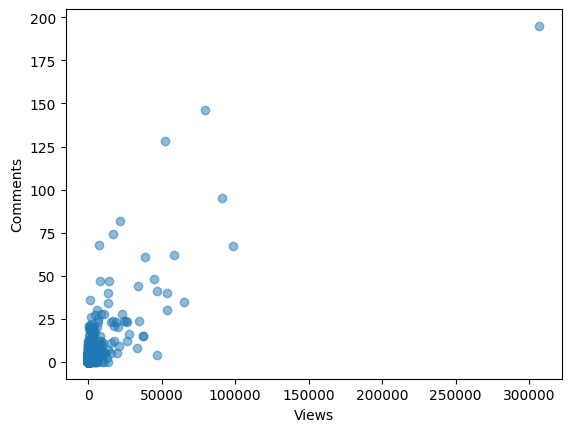

In [21]:
plt.scatter(df['views'], df['comments'], alpha=0.5)  
plt.xlabel('Views')
plt.ylabel('Comments')

Text(0, 0.5, 'Views')

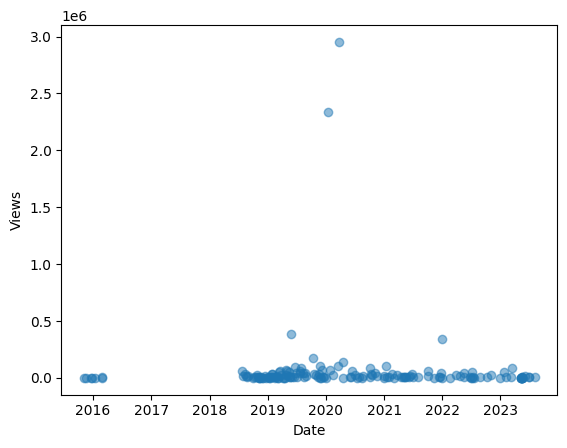

In [9]:
plt.scatter(df['date'], df['views'], alpha=0.5)  
plt.xlabel('Date')
plt.ylabel('Views')

C:\Users\brian\AppData\Local\Temp\ipykernel_27892\3895876521.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df.rename(columns={'date': 'ds', 'views': 'y'}, inplace=True)
C:\Users\brian\AppData\Local\Temp\ipykernel_27892\3895876521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df.drop(columns=['index'], inplace=True)
08:01:41 - cmdstanpy - INFO - Chain [1] start processing
08:01:41 - cmdstanpy - INFO - Chain [1] done processing


             ds
1850 2026-03-19
1851 2026-03-20
1852 2026-03-21
1853 2026-03-22
1854 2026-03-23


c:\Trabajos\web\social-analyzer-api\.venv\Lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Trabajos\web\social-analyzer-api\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


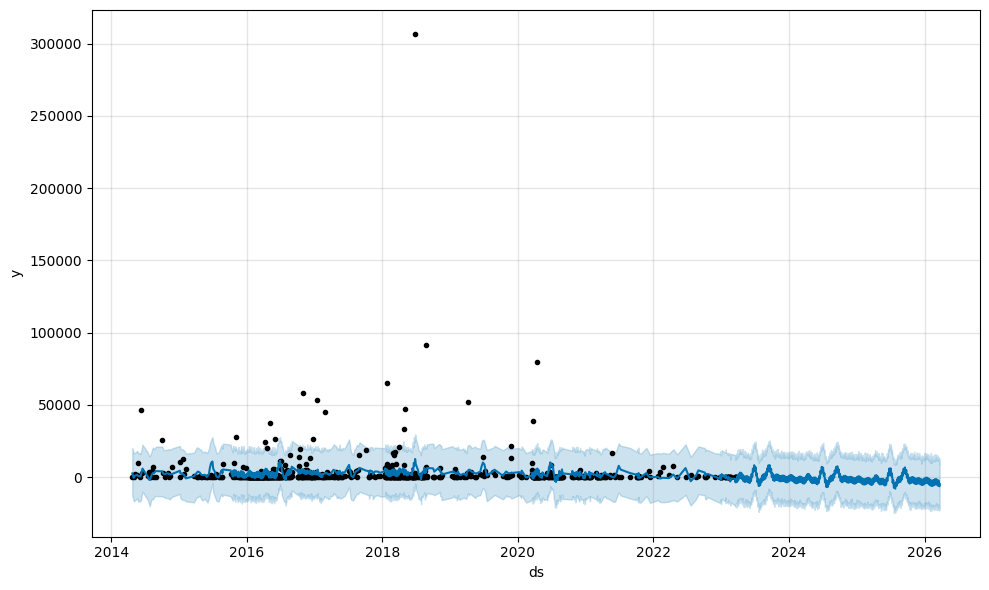

In [62]:
from prophet import Prophet

date_df = df[['date', 'views']]
date_df.reset_index(inplace=True)
date_df.rename(columns={'date': 'ds', 'views': 'y'}, inplace=True)
date_df.drop(columns=['index'], inplace=True)
date_df = date_df.dropna(subset=['ds', 'y'])
m = Prophet()
m.fit(date_df)
future = m.make_future_dataframe(periods=1095)
print(future.tail())
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
